In [2]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import dateparser  

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, roc_curve
from sklearn.neighbors import NearestNeighbors

from pymorphy3 import MorphAnalyzer
from gensim.models import Word2Vec

import re
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [4]:
DB_FILE = "news.db"

conn = sqlite3.connect(DB_FILE)

df = pd.read_sql_query("SELECT * FROM news;", conn)

conn.close()

In [6]:
df.head()

,guid,title,description,url,published_at,comments_count,rating,created_at_utc
0,448dd01f-ac89-454c-9712-3f2b7b9f3196,«Почему не взлетаем?»: специалист центра управ...,«Ковры» и другие нештатные ситуации прокоммент...,https://www.e1.ru/text/gorod/2025/12/15/76167495/,2025-12-15T10:00:16+05:00,NaN,None,2025-12-18T11:32:28.630644+00:00
1,cb3db44d-05c2-4a86-8525-beefc47f74cd,Скандальный поселок под Екатеринбургом остался...,"Подстанция сгорела, дома обесточены\nЖители по...",https://www.e1.ru/text/house/2025/12/18/76177490/,2025-12-18T14:26:34+05:00,NaN,None,2025-12-18T11:32:30.275257+00:00
2,a68c11ea-3fd9-4f64-835f-fdb3f099fb29,Заманивал под лестницу и обещал конфетки. В Ек...,Пенсионера отправили под арест\nВладимиру Азан...,https://www.e1.ru/text/criminal/2025/12/18/761...,2025-12-18T14:04:00+05:00,NaN,None,2025-12-18T11:32:31.859688+00:00
3,49c2cc30-cb81-4a8c-ba39-05b63288760a,Будет еще холоднее! В Свердловскую область при...,Синоптики обновили экстренное предупреждение\n...,https://www.e1.ru/text/winter/2025/12/18/76177...,2025-12-18T13:21:41+05:00,NaN,None,2025-12-18T11:32:34.615201+00:00
4,e7427d62-3533-4dd3-942e-4593be9aa364,В Екатеринбурге маме 10-месячной малышки отказ...,Объясняем тонкости ситуации\nРазговор с врачом...,https://www.e1.ru/text/health/2025/12/18/76177...,2025-12-18T11:29:42+05:00,NaN,None,2025-12-18T11:32:36.205155+00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   guid            6208 non-null   object 
 1   title           6208 non-null   object 
 2   description     6208 non-null   object 
 3   url             6208 non-null   object 
 4   published_at    6072 non-null   object 
 5   comments_count  1800 non-null   float64
 6   rating          0 non-null      object 
 7   created_at_utc  6208 non-null   object 
dtypes: float64(1), object(7)
memory usage: 388.1+ KB


In [10]:
df.isna().sum()

guid                 0
title                0
description          0
url                  0
published_at       136
comments_count    4408
rating            6208
created_at_utc       0
dtype: int64

In [12]:
df = df.dropna(subset=['published_at'])

In [140]:
def fix_datetime(dt_str):
    if pd.isna(dt_str):
        return pd.NaT
    try:
        return pd.to_datetime(dt_str, utc=True)
    except:
        return pd.NaT

df["published_at"] = df["published_at"].apply(fix_datetime)

df["published_at"] = pd.to_datetime(df["published_at"])

df['created_at_utc'] = pd.to_datetime(df['created_at_utc'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6072 entries, 0 to 6207
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   guid            6072 non-null   object             
 1   title           6072 non-null   object             
 2   description     6072 non-null   object             
 3   url             6072 non-null   object             
 4   published_at    6072 non-null   datetime64[ns, UTC]
 5   comments_count  1800 non-null   float64            
 6   rating          0 non-null      object             
 7   created_at_utc  6072 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), object(5)
memory usage: 426.9+ KB


In [22]:
df

,guid,title,description,url,published_at,comments_count,rating,created_at_utc
0,448dd01f-ac89-454c-9712-3f2b7b9f3196,«Почему не взлетаем?»: специалист центра управ...,«Ковры» и другие нештатные ситуации прокоммент...,https://www.e1.ru/text/gorod/2025/12/15/76167495/,2025-12-15 05:00:16+00:00,NaN,None,2025-12-18 11:32:28.630644+00:00
1,cb3db44d-05c2-4a86-8525-beefc47f74cd,Скандальный поселок под Екатеринбургом остался...,"Подстанция сгорела, дома обесточены\nЖители по...",https://www.e1.ru/text/house/2025/12/18/76177490/,2025-12-18 09:26:34+00:00,NaN,None,2025-12-18 11:32:30.275257+00:00
2,a68c11ea-3fd9-4f64-835f-fdb3f099fb29,Заманивал под лестницу и обещал конфетки. В Ек...,Пенсионера отправили под арест\nВладимиру Азан...,https://www.e1.ru/text/criminal/2025/12/18/761...,2025-12-18 09:04:00+00:00,NaN,None,2025-12-18 11:32:31.859688+00:00
3,49c2cc30-cb81-4a8c-ba39-05b63288760a,Будет еще холоднее! В Свердловскую область при...,Синоптики обновили экстренное предупреждение\n...,https://www.e1.ru/text/winter/2025/12/18/76177...,2025-12-18 08:21:41+00:00,NaN,None,2025-12-18 11:32:34.615201+00:00
4,e7427d62-3533-4dd3-942e-4593be9aa364,В Екатеринбурге маме 10-месячной малышки отказ...,Объясняем тонкости ситуации\nРазговор с врачом...,https://www.e1.ru/text/health/2025/12/18/76177...,2025-12-18 06:29:42+00:00,NaN,None,2025-12-18 11:32:36.205155+00:00
...,...,...,...,...,...,...,...,...
6203,215f501c-4a69-4465-8109-3a68d3702f4d,Соцфонд назвал средний размер прибавки к пенси...,"Средний размер выплат, который получают россия...",https://www.banki.ru/news/lenta/?id=11013809,2025-05-07 00:00:00+00:00,NaN,None,2025-12-18 16:28:53.073523+00:00
6204,e523d38f-0841-4cb8-9b96-e9ac839ddcde,Авиакомпании в России массово задерживают и от...,Авиакомпании сообщают о возможных вынужденных ...,https://www.banki.ru/news/lenta/?id=11013807,2025-05-07 00:00:00+00:00,NaN,None,2025-12-18 16:28:54.797080+00:00
6205,a5ee7e01-3d8e-47a1-9ab7-723397006ec9,Сбербанк предупредил клиентов о сложностях с д...,Из-за возможных перебоев в работе мобильного и...,https://www.banki.ru/news/lenta/?id=11013805,2025-05-07 00:00:00+00:00,NaN,None,2025-12-18 16:28:58.994882+00:00
6206,a06f6857-669c-426f-808d-f6e224a3a9fd,Банки массово подключают клиентам платные услу...,Дайджест деловых СМИ.\n📰 Доля Райффайзенбанка ...,https://www.banki.ru/news/lenta/?id=11013803,2025-05-07 00:00:00+00:00,NaN,None,2025-12-18 16:29:03.967064+00:00


Пропуски в comments_count: 4272
Пропуски в rating: 6072


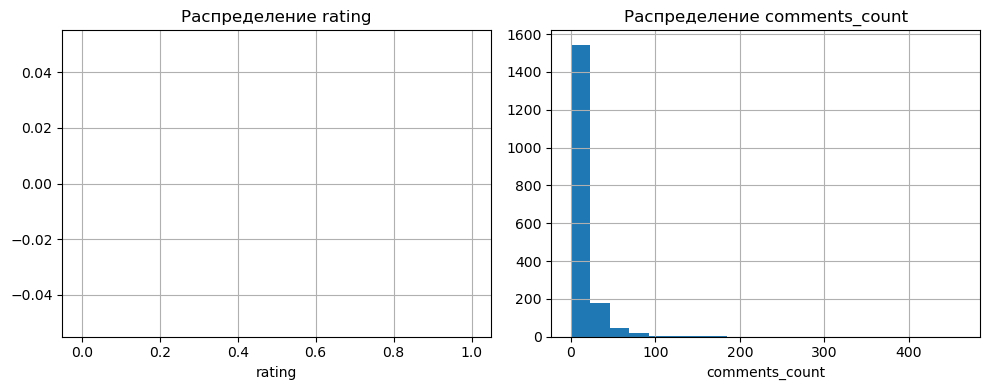

In [24]:
print("Пропуски в comments_count:", df["comments_count"].isna().sum())
print("Пропуски в rating:", df["rating"].isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df["rating"].hist(ax=axes[0], bins=20)
axes[0].set_title("Распределение rating")
axes[0].set_xlabel("rating")

df["comments_count"].hist(ax=axes[1], bins=20)
axes[1].set_title("Распределение comments_count")
axes[1].set_xlabel("comments_count")

plt.tight_layout()
plt.show()

In [138]:
df['rating'] = df['rating'].replace([None], np.nan)

imputer_zero = SimpleImputer(strategy="constant", fill_value=0)
zero_columns = ["comments_count", "rating"]

df[zero_col] = imputer_zero.fit_transform(df[zero_columns])

df["comments_count"] = df["comments_count"].astype(int)

df["rating"] = df["rating"].astype(int)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6072 entries, 0 to 6207
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   guid            6072 non-null   object             
 1   title           6072 non-null   object             
 2   description     6072 non-null   object             
 3   url             6072 non-null   object             
 4   published_at    6072 non-null   datetime64[ns, UTC]
 5   comments_count  6072 non-null   int32              
 6   rating          6072 non-null   int32              
 7   created_at_utc  6072 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int32(2), object(4)
memory usage: 379.5+ KB


In [34]:
df.isna().sum()

guid              0
title             0
description       0
url               0
published_at      0
comments_count    0
rating            0
created_at_utc    0
dtype: int64

In [36]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [37]:
morph = MorphAnalyzer()
RUSSIAN_STOPWORDS = set(stopwords.words("russian"))

TOKEN_RE = re.compile(r"[А-Яа-яA-Za-z]+", flags=re.U)


def preprocess_text(text: str):
    """
    Полная предобработка одного текста:
    - приведение к нижнему регистру,
    - выделение токенов,
    - фильтрация по длине и стоп-словам,
    - лемматизация через pymorphy3.

    Возвращает список лемм (строк).
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = text.lower()
    tokens = TOKEN_RE.findall(text)

    lemmas = []
    for token in tokens:
        # Отсекаем короткий мусор
        if len(token) <= 2:
            continue

        # Русские и латинские слова отдельно
        if re.match(r"[а-я]", token):
            # Русское слово: нормальная форма через pymorphy3
            if token in RUSSIAN_STOPWORDS:
                continue
            parsed = morph.parse(token)[0]
            lemma = parsed.normal_form
            if lemma in RUSSIAN_STOPWORDS:
                continue
        else:
            # Латинское/английское слово — оставляем как есть
            lemma = token

        lemmas.append(lemma)

    return lemmas

In [40]:
sample_text = df["description"].iloc[0]
print(sample_text[:100], "...")

preprocess_text(sample_text)[:100]

«Ковры» и другие нештатные ситуации прокомментировал начальник оперативной смены
Попасть на задержку ...


['ковёр',
 'нештатный',
 'ситуация',
 'прокомментировать',
 'начальник',
 'оперативный',
 'смена',
 'попасть',
 'задержка',
 'рейс',
 'неприятно',
 'веский',
 'причина',
 'дмитрий',
 'сергеев',
 'наверняка',
 'каждый',
 'летать',
 'самолёт',
 'попадать',
 'задержка',
 'рейс',
 'это',
 'неприятно',
 'почему',
 'это',
 'происходить',
 'почему',
 'воздушный',
 'суд',
 'отправляться',
 'путь',
 'вовремя',
 'особенно',
 'настоящий',
 'время',
 'воздушный',
 'пространство',
 'нередко',
 'закрывать',
 'сигнал',
 'ковёр',
 'информация',
 'ответ',
 'вопрос',
 'который',
 'волновать',
 'каждый',
 'земля',
 'небо',
 'отправиться',
 'аэропорт',
 'познакомиться',
 'заместитель',
 'начальник',
 'центр',
 'управление',
 'полёт',
 'цуп',
 'оперативный',
 'управление',
 'полёт',
 'уральский',
 'авиалиния',
 'гелый',
 'беридзе',
 'который',
 'вместе',
 'свой',
 'коллега',
 'отвечать',
 'расписание',
 'доставить',
 'пассажир',
 'место',
 'назначение',
 'гесть',
 'беридзе',
 'стать',
 'герой',
 'первый',


In [42]:
N_DOCS = 6072  

texts = df["description"].iloc[:N_DOCS].tolist()

tokenized_texts = [preprocess_text(t) for t in texts]

# Смотрим пример
tokenized_texts[0][:40]

['ковёр',
 'нештатный',
 'ситуация',
 'прокомментировать',
 'начальник',
 'оперативный',
 'смена',
 'попасть',
 'задержка',
 'рейс',
 'неприятно',
 'веский',
 'причина',
 'дмитрий',
 'сергеев',
 'наверняка',
 'каждый',
 'летать',
 'самолёт',
 'попадать',
 'задержка',
 'рейс',
 'это',
 'неприятно',
 'почему',
 'это',
 'происходить',
 'почему',
 'воздушный',
 'суд',
 'отправляться',
 'путь',
 'вовремя',
 'особенно',
 'настоящий',
 'время',
 'воздушный',
 'пространство',
 'нередко',
 'закрывать']

In [44]:
w2v_model = Word2Vec(
    sentences=tokenized_texts,  # список документов, каждый документ = список лемм
    vector_size=120,            # размерность эмбеддинга слова
    window=5,                   # ширина контекста
    min_count=5,                # игнорируем слова реже 5 раз
    workers=4,                  # параллельные потоки
    sg=1,                       # 1 = Skip-gram, 0 = CBOW
    epochs=10,                  # сколько раз пройтись по корпусу
)

w2v_model

In [46]:
w2v_model.wv.most_similar("начальник", topn=10)

[('хирург', 0.7769362330436707),
 ('савинов', 0.7691479921340942),
 ('клинический', 0.7688890695571899),
 ('алексеев', 0.7604343295097351),
 ('беридзе', 0.7578616142272949),
 ('терапевт', 0.7537742853164673),
 ('гидрометцентр', 0.7531089782714844),
 ('вадим', 0.7392062544822693),
 ('советник', 0.7386327981948853),
 ('замначальник', 0.7334147691726685)]

In [48]:
for test_word in ["хирург", "советник", "терапевт", "замначальник", "клинический"]:
    if test_word not in w2v_model.wv:
        continue

    print(f"\nПохожие слова для «{test_word}»:")
    for word, score in w2v_model.wv.most_similar(test_word, topn=5):
        print(f"  {word:15s} {score:.3f}")


Похожие слова для «хирург»:
  савинов         0.870
  медсестра       0.868
  терапевт        0.868
  пациентка       0.861
  акушер          0.859

Похожие слова для «советник»:
  плеханов        0.866
  кафедра         0.862
  рэу             0.861
  доцент          0.857
  зампредседателя 0.855

Похожие слова для «терапевт»:
  клинический     0.868
  хирург          0.868
  максимов        0.864
  шестаков        0.862
  зоолог          0.860

Похожие слова для «замначальник»:
  секретарь       0.878
  филиппов        0.860
  кирюхин         0.847
  савинов         0.844
  хирург          0.843

Похожие слова для «клинический»:
  терапевт        0.868
  хирург          0.849
  медсестра       0.843
  акушер          0.832
  гинеколог       0.829


In [50]:
def document_vector(tokens, model: Word2Vec):
    """
    Строит вектор документа как среднее по векторам слов.
    Слова, которых нет в модели, игнорируются.
    Если нет ни одного слова, выдаём нулевой вектор.
    """
    vectors = [model.wv[token] for token in tokens if token in model.wv]

    if not vectors:
        return np.zeros(model.vector_size, dtype="float32")

    return np.mean(vectors, axis=0)



doc_vectors = np.vstack([document_vector(tokens, w2v_model) for tokens in tokenized_texts])
doc_vectors.shape

(6072, 120)

In [52]:
doc_vectors[:3]

array([[ 0.25535643, -0.33656877, -0.06762237,  0.17083192,  0.11356892,
        -0.10716037,  0.11667726, -0.08304117, -0.13109273,  0.15792322,
         0.06145981, -0.06083925, -0.02014132,  0.10660091, -0.10127773,
         0.03560875, -0.07011697, -0.00805345,  0.11570586,  0.0905655 ,
         0.04469568, -0.21214706,  0.07931821, -0.00398483,  0.0806505 ,
         0.35805672, -0.25443107,  0.21836784, -0.17474957, -0.12629291,
        -0.24193044, -0.16646485,  0.09889101, -0.00893981,  0.00887104,
        -0.02006569, -0.09439755, -0.06887645,  0.03471667,  0.10711823,
         0.03876981, -0.0249529 , -0.1669524 , -0.2688551 ,  0.12443893,
        -0.05575117,  0.075799  , -0.21001175,  0.05375993,  0.14827038,
        -0.12420229,  0.02018901, -0.06391679,  0.22621094,  0.16011597,
         0.05736846, -0.1708528 , -0.05918805,  0.07279612, -0.00371134,
         0.1276031 ,  0.13506784,  0.10001703,  0.28968006, -0.10492733,
         0.06228976,  0.25131148,  0.2029882 ,  0.1

In [56]:
pca = PCA(n_components=2, random_state=42)

doc_vectors_2d = pca.fit_transform(doc_vectors)
doc_vectors_2d[:5]

array([[ 0.00332057, -0.3238707 ],
       [-0.10947806, -0.341225  ],
       [-0.09505191, -0.49098608],
       [ 0.12381607, -0.18133077],
       [ 0.09379238, -0.47084466]], dtype=float32)

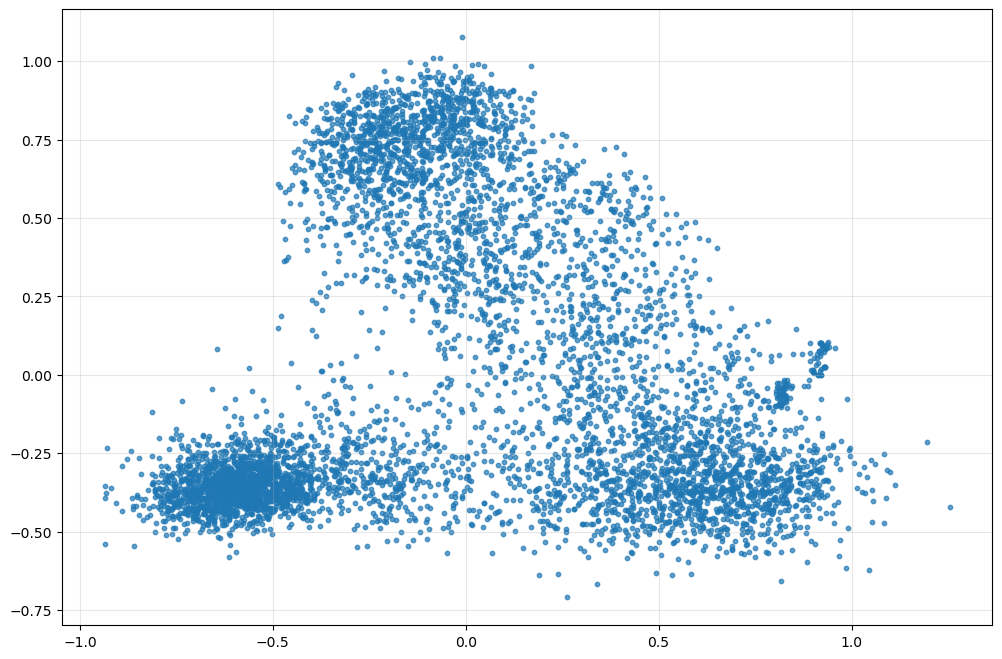

In [57]:
plt.figure(figsize=(12, 8))
plt.scatter(
    doc_vectors_2d[:, 0], 
    doc_vectors_2d[:, 1], 
    alpha=0.7, 
    s=10
)

plt.grid(True, alpha=0.3)
plt.show()

In [60]:
df_subset = df.iloc[:N_DOCS].copy()
df_subset["pca_x"] = doc_vectors_2d[:, 0]
df_subset["pca_y"] = doc_vectors_2d[:, 1]

df_subset.head()

,guid,title,description,url,published_at,comments_count,rating,created_at_utc,pca_x,pca_y
0,448dd01f-ac89-454c-9712-3f2b7b9f3196,«Почему не взлетаем?»: специалист центра управ...,«Ковры» и другие нештатные ситуации прокоммент...,https://www.e1.ru/text/gorod/2025/12/15/76167495/,2025-12-15 05:00:16+00:00,0,0,2025-12-18 11:32:28.630644+00:00,0.003321,-0.323871
1,cb3db44d-05c2-4a86-8525-beefc47f74cd,Скандальный поселок под Екатеринбургом остался...,"Подстанция сгорела, дома обесточены\nЖители по...",https://www.e1.ru/text/house/2025/12/18/76177490/,2025-12-18 09:26:34+00:00,0,0,2025-12-18 11:32:30.275257+00:00,-0.109478,-0.341225
2,a68c11ea-3fd9-4f64-835f-fdb3f099fb29,Заманивал под лестницу и обещал конфетки. В Ек...,Пенсионера отправили под арест\nВладимиру Азан...,https://www.e1.ru/text/criminal/2025/12/18/761...,2025-12-18 09:04:00+00:00,0,0,2025-12-18 11:32:31.859688+00:00,-0.095052,-0.490986
3,49c2cc30-cb81-4a8c-ba39-05b63288760a,Будет еще холоднее! В Свердловскую область при...,Синоптики обновили экстренное предупреждение\n...,https://www.e1.ru/text/winter/2025/12/18/76177...,2025-12-18 08:21:41+00:00,0,0,2025-12-18 11:32:34.615201+00:00,0.123816,-0.181331
4,e7427d62-3533-4dd3-942e-4593be9aa364,В Екатеринбурге маме 10-месячной малышки отказ...,Объясняем тонкости ситуации\nРазговор с врачом...,https://www.e1.ru/text/health/2025/12/18/76177...,2025-12-18 06:29:42+00:00,0,0,2025-12-18 11:32:36.205155+00:00,0.093792,-0.470845


In [62]:
X_kmeans = doc_vectors_2d  

In [70]:
inertias = []
silhouettes = []

K = range(2, 16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_kmeans)

    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_kmeans, kmeans.labels_))

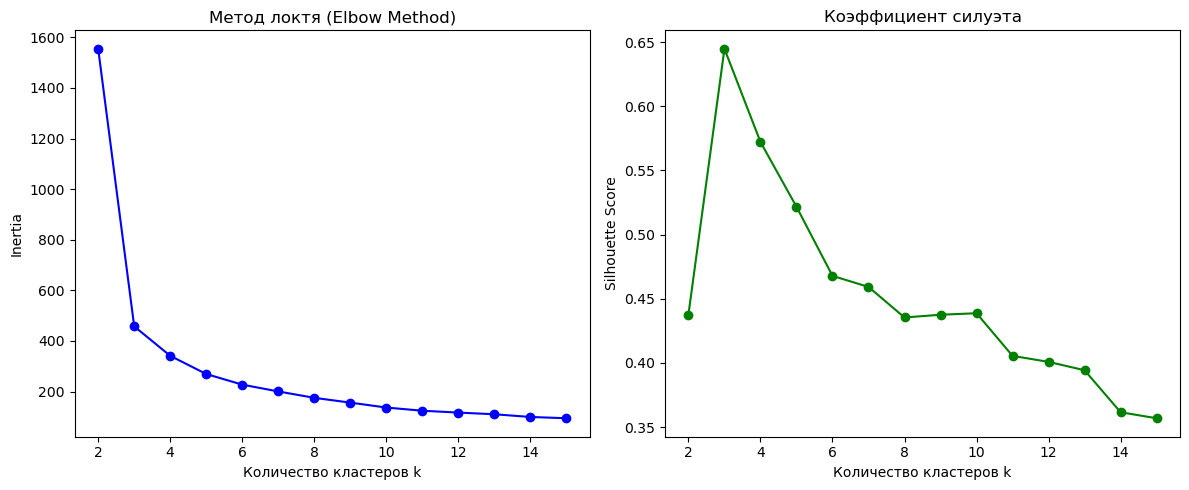

In [71]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя (Elbow Method)')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'go-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта')
plt.tight_layout()
plt.show()

In [76]:
kmeans_best = KMeans(n_clusters=3, random_state=42)
kmeans_best.fit(X_kmeans)

KMeans(n_clusters=3, random_state=42)

In [78]:
clusters_km = kmeans_best.labels_

df_subset["cluster"] = clusters_km

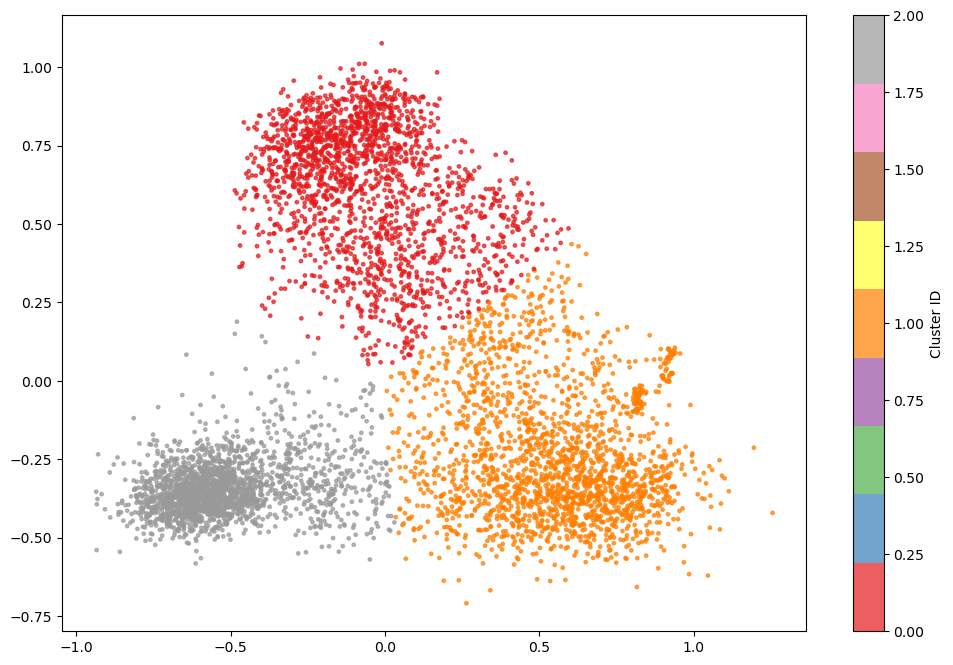

In [84]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_subset["pca_x"],
    df_subset["pca_y"],
    c=df_subset["cluster"],
    s=6,
    cmap="Set1",
    alpha=0.7,
)
plt.colorbar(scatter, label="Cluster ID")
plt.show()

In [86]:
df_subset["cluster"].value_counts()

cluster
1    2097
2    2036
0    1939
Name: count, dtype: int64

In [352]:
for i in range(3):

    cluster_titles = df_subset[df_subset['cluster']==i]['title'].head(15)
    for i, title in enumerate(cluster_titles, 1):
        print(f"{i:2d}. {title}")

 1. В Екатеринбург привезли очень дорогой и редкий спорткар. Год назад такой же продавали за миллиард
 2. Вместо «русского Прадо»: оцениваем внедорожник, который запускают на УАЗе в 2026 году
 3. Готовы спустить миллионы на елку? Показываем, сколько просят за самые дорогие новогодние деревья
 4. На крупном уральском заводе разгорелся пожар. Видео
 5. В Екатеринбурге выставили на продажу самую большую квартиру города. Она стоит безумных денег
 6. Дорожники перекрыли Пермский тракт из-за фуры, которая там опрокинулась
 7. Отказ от запрета ДВС в Европе поддержали не все производители
 8. В Лас-Вегасе дебютирует загадочный автобренд Kosmera из Китая
 9. Перечислены требования, которым должны будут соответствовать дверные ручки автомобилей в Китае
10. Уникальный Porsche 356, принадлежавший знаменитому музыканту, выставили на торги
11. 7 миллионов Hyundai и Kia бесплатно дооснастят «противоугонками»
12. Tesla запатентовала решение для подключения электрокаров к спутникам Starlink
13. BYD раз

In [90]:
y = df_subset["cluster"]

X = doc_vectors_2d

In [92]:
X.shape

(6072, 2)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((4857, 2), (1215, 2))

## DecisionTreeClassifier

In [100]:
params_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt'],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

tree = DecisionTreeClassifier(random_state=42)

GS_tree = GridSearchCV(
    estimator=tree,
    param_grid=params_tree,
    cv=5,                    
    scoring='accuracy',     
    n_jobs=-1,               
    verbose=1
)

GS_tree.fit(X_train, y_train)

print(f"Лучшие параметры: {GS_tree.best_params_}")
print(f"Лучший score: {GS_tree.best_score_:.3f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10}
Лучший score: 0.991


In [130]:
best_tree = GS_tree.best_estimator_
test_score_tree = best_tree.score(X_test, y_test)

y_pred_tree = best_tree.predict(X_test)

report_matrix_km = classification_report(y_test, y_pred_tree, output_dict=True)

In [132]:
for label, metrics in report_matrix_km.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {label}: F1 = {metrics['f1-score']:.3f}")
        print(f"Class {label}: recall = {metrics['recall']:.3f}")
        print(f"Class {label}: precision = {metrics['precision']:.3f}")

Class 0: F1 = 0.982
Class 0: recall = 0.987
Class 0: precision = 0.977
Class 1: F1 = 0.987
Class 1: recall = 0.983
Class 1: precision = 0.990
Class 2: F1 = 0.996
Class 2: recall = 0.995
Class 2: precision = 0.998


## KNeighborsClassifier

In [128]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20, 30],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()

GS_knn = GridSearchCV(
    knn,
    param_grid=params_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

GS_knn.fit(X_train, y_train)

print(f"Лучшие параметры: {GS_knn.best_params_}")
print(f"Лучший CV score: {GS_knn.best_score_:.3f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Лучшие параметры: {'metric': 'chebyshev', 'n_neighbors': 30, 'p': 1, 'weights': 'distance'}
Лучший CV score: 0.998


In [134]:
best_knn = GS_knn.best_estimator_

y_pred_knn = best_knn.predict(X_test)

report_matrix_knn = classification_report(y_test, y_pred_knn, output_dict=True)

In [136]:
for label, metrics in report_matrix_knn.items():
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"Class {label}: F1 = {metrics['f1-score']:.3f}")
        print(f"Class {label}: recall = {metrics['recall']:.3f}")
        print(f"Class {label}: precision = {metrics['precision']:.3f}")

Class 0: F1 = 0.996
Class 0: recall = 0.997
Class 0: precision = 0.995
Class 1: F1 = 0.998
Class 1: recall = 0.998
Class 1: precision = 0.998
Class 2: F1 = 0.999
Class 2: recall = 0.998
Class 2: precision = 1.000
